In [31]:
import numpy as np
import matplotlib.pyplot as plt
#Comment out the next line if it doesn't run
%matplotlib widget 

In [32]:
class Atmosphere:
    def __init__(self, shape):
        self.shape = shape
        self.source_function = np.zeros(shape)
        self.albedo = 1.0

    def in_box(self, position):
        return all(0 <= position[i] < self.shape[i] for i in range(3))
    
    def distance_to_boundary(self, position, direction):
        """
        Calculate the distance to the boundary of the 3D grid from a given position in a given direction.
        position: (x, y, z) coordinates of the starting point
        direction: (dx, dy, dz) direction vector
        Returns: distance to the boundary
        """
        distances = []
        for i in range(3):
            if direction[i] > 0:
                boundary = self.shape[i]
                distance = (boundary - position[i]) / direction[i]
            elif direction[i] < 0:
                boundary = 0
                distance = (boundary - position[i]) / direction[i]
            else:
                distance = float('inf')  # No movement in this direction
            distances.append(distance)
        return min(distances)
    
    def distance_to_planes(self, position, direction):
        """
        Calculate the parametric distances to the next planes in a 3D grid.
        position: (x, y, z) coordinates of the starting point
        direction: (dx, dy, dz) direction vector
        Returns: (tMaxX, tMaxY, tMaxZ) parametric distances to the next planes
        """
        
        x, y, z = position
        # Determine the next face coordinates based on direction
        faceX = np.floor(x) + 1 if direction[0] > 0 else np.floor(x)
        faceY = np.floor(y) + 1 if direction[1] > 0 else np.floor(y)
        faceZ = np.floor(z) + 1 if direction[2] > 0 else np.floor(z)

        tMaxX = (faceX - x) / direction[0] if direction[0] != 0 else float('inf')
        tMaxY = (faceY - y) / direction[1] if direction[1] != 0 else float('inf')
        tMaxZ = (faceZ - z) / direction[2] if direction[2] != 0 else float('inf')

        return tMaxX, tMaxY, tMaxZ

    def parametric_distance_in_cell(self, direction, cell_sizes=(1,1,1)):
        """
        Calculate the parametric distances to the cell boundaries.
        direction: (dx, dy, dz) direction vector
        cell_sizes: (sx, sy, sz) sizes of the cells in each dimension
        Returns: (tDeltaX, tDeltaY, tDeltaZ) parametric distances to the cell boundaries
        """

        tDeltaX = cell_sizes[0] / abs(direction[0]) if direction[0] != 0 else float('inf')
        tDeltaY = cell_sizes[1] / abs(direction[1]) if direction[1] != 0 else float('inf')
        tDeltaZ = cell_sizes[2] / abs(direction[2]) if direction[2] != 0 else float('inf')

        return tDeltaX, tDeltaY, tDeltaZ

    def compute_length_in_cells(self, initial_position, depth, direction):
        """
        Compute the length of the ray in each cell it traverses.
        position: (x, y, z) coordinates of the starting point
        direction: (dx, dy, dz) direction vector
        Returns: 3D array of lengths in each cell
        """
        length_in_cell = np.zeros(self.shape)
        if not self.in_box(initial_position):
            return length_in_cell
        # Determine step directions
        stepX = 1 if direction[0] > 0 else -1
        stepY = 1 if direction[1] > 0 else -1
        stepZ = 1 if direction[2] > 0 else -1

        # Initial distances to the next planes
        tMaxX, tMaxY, tMaxZ = self.distance_to_planes(initial_position, direction)
        t_curr = np.min([tMaxX, tMaxY, tMaxZ])
        length_in_cell[np.floor(initial_position).astype(int)[0], np.floor(initial_position).astype(int)[1], np.floor(initial_position).astype(int)[2]] += t_curr

        # Parametric distances to cross a cell
        tDeltaX, tDeltaY, tDeltaZ = self.parametric_distance_in_cell(direction)
        # Current cell indices
        Xcell, Ycell, Zcell = np.floor(initial_position).astype(int)

        while self.in_box([Xcell, Ycell, Zcell]) and t_curr < depth: 
            if tMaxX < tMaxY and tMaxX < tMaxZ:
                t_next = tMaxX
            elif tMaxY < tMaxX and tMaxY < tMaxZ:
                t_next = tMaxY
            else:
                t_next = tMaxZ

            delta = min(t_next, depth) - t_curr
            length_in_cell[Xcell, Ycell, Zcell] += delta

            if t_next == tMaxX:
                tMaxX += tDeltaX
                Xcell += stepX
            elif t_next == tMaxY:
                tMaxY += tDeltaY
                Ycell += stepY
            else:
                tMaxZ += tDeltaZ
                Zcell += stepZ

            t_curr = min(t_next, depth)
        
        return length_in_cell

    def deposit_energy(self, initial_position, depth, direction, energy):
        
        if not self.in_box(initial_position + direction * depth):
            depth = self.distance_to_boundary(initial_position, direction)

        lengths = self.compute_length_in_cells(initial_position, depth, direction)

        self.source_function += lengths * energy * self.albedo / (4 * np.pi)

class PhotonPacket:

    def __init__(self, position, energy):
        self.position = np.array(position)
        self.energy = energy
        self.trajectory = [position]
        self.energy_threshold = 1e-6
    
    def direction_in_cartesian(self, theta, phi):
        dx = np.sin(theta) * np.cos(phi)
        dy = np.sin(theta) * np.sin(phi)
        dz = np.cos(theta)
        return np.array([dx, dy, dz])
    
    def maximum_optical_depth(self):
        return -np.log(self.energy_threshold / self.energy)
    
    def get_random_walk(self):
        random_optical_depth = -np.log(np.random.random())
        optical_depth = min(random_optical_depth, self.maximum_optical_depth())
        phi = 2 * np.pi * np.random.random()
        theta = np.arccos(2 * np.random.random() - 1)

        return optical_depth, theta, phi
    
    def move(self, r, theta, phi):

        direction = self.direction_in_cartesian(theta, phi)
        new_position = self.position + r * direction
        self.position = new_position
        self.trajectory = np.append(self.trajectory, [new_position], axis=0)

    def energy_loss(self, tau):
        self.energy *= np.exp(-tau)


class Simulation:
    def __init__(self, atmosphere, photon_packets):
        self.atmosphere = atmosphere
        self.photons = photon_packets

    def run(self):
        
        for photon in self.photons:
            while photon.energy > photon.energy_threshold and self.atmosphere.in_box(photon.position):

                tau, theta, phi = photon.get_random_walk()
                direction = photon.direction_in_cartesian(theta, phi)
                self.atmosphere.deposit_energy(photon.position, tau, direction, photon.energy)
                photon.energy_loss(tau)
                photon.move(tau, theta, phi)

In [33]:
N = 1
boxsize = (10, 10, 10)
x, y, z = boxsize[0]/2, boxsize[1]/2, boxsize[2]-0.001
initial = (x, y, z)



photons = [PhotonPacket(initial, 100.0) for _ in range(N)]
atm = Atmosphere(boxsize)
sim = Simulation(atm, photons)
sim.run()

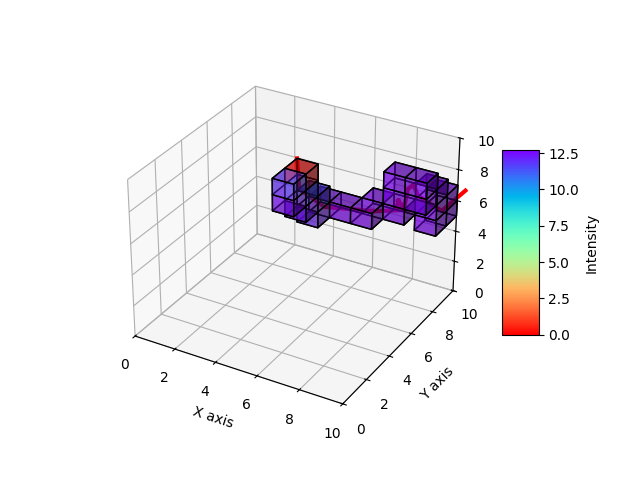

In [34]:
import matplotlib.cm as cm
import matplotlib.colors as colors

norm = colors.Normalize(vmin=np.min(atm.source_function), vmax=np.max(atm.source_function))
facecolors = cm.rainbow(norm(atm.source_function))

plt.figure()
ax = plt.axes(projection='3d')
ax.voxels(atm.source_function > 0, facecolors=facecolors, edgecolor='k', alpha=0.5)
for i in range(N):
    ax.plot(
        photons[i].trajectory[:,0],
        photons[i].trajectory[:,1],
        photons[i].trajectory[:,2],
        color='r', linewidth=3, label='Ray Path'
)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, boxsize[0])
ax.set_ylim(0, boxsize[1])
ax.set_zlim(0, boxsize[2])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow_r'), ax=ax, shrink=0.5, aspect=5, label='Intensity')
plt.show()

In [35]:
photons[0].energy

np.float64(1e-06)